## Preprocess DataFrame and Handle Categorical Features for Clustering

Project Goal: Cluster users together to recommend songs.

This notebook focuses on preprocessing the `users_df` for clustering. The steps taken include:

*   **Handling Missing Values:** Rows with NaN values were dropped.
*   **Outlier Consideration and Scaling:** Instead of dropping users based on a play count cutoff, numerical features were scaled using `RobustScaler`, which is less sensitive to outliers than `MinMaxScaler` or `StandardScaler`. We did because we think there is value in knowing the preferred songs of power users.
*   **Categorical Feature Encoding:** We explored one-hot encoding for categorical features. Due to the high number of unique values in 'fav\_song' (over 119,000 unique values) and 'fav\_artist' (over 14,000 unique values), one-hot encoding both of these columns is not feasible due to memory constraints. We decided on only encoding 'fav\_artist'. We identified that 'fav\_maj\_genre' and 'fav\_min\_genre' have manageable unique values for one-hot encoding.

The preprocessed data, `users_df_encoded` (which includes our transformations), is now prepared for further analysis, such as dimensionality reduction with PCA and subsequent K-Means clustering. We save this processed df to our drive so that we can logically separate notebooks and not recompute.

### Load Data

In [1]:
!pip install pyarrow  # to save data to a parquet file

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [3]:
# if local
cleaned_users_path = "data/users_cleaned_df.parquet"

In [4]:
# # if collab
# from google.colab import drive
#
# drive.mount('/content/drive')
# cleaned_users_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df.parquet"

In [5]:
users_polars_df = pl.read_parquet(cleaned_users_path)

In [6]:
users_df_original = users_polars_df.to_pandas(use_pyarrow_extension_array=True)
users_df = users_df_original.copy()

### EDA and preprocessing
We thought we would drop outlier users but decided against it and went for a scaler that accounts for outliers. We include some of our EDA.

In [7]:
users_df[users_df['user_id'] == '093cb74eb3c517c5179ae24caf0ebec51b24d2a2']

,user_id,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_genre,fav_maj_count,fav_min_genre,fav_min_count,fav_year,year_count,fav_artist,fav_artist_plays,fav_song,fav_song_plays,fav_song_duration,tot_fav_song_play_time
33488,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,11697,2408769.69526,98,98,Rock,39,Rock,8,2009,17,AR4DW2Q1187FB44DB6,3,SOAOSDF12A58A779F1,9667,201.56036,1948484.00012


In [8]:
users_df = users_df.dropna()

In [9]:
users_df.describe()

,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0,933431.0
mean,75.07252,18605.09512,27.352648,27.352648,15.393956,3.465819,2001.04953,5.766003,5.351766,12.863076,250.97062,3232.460024
std,106.195572,26308.410928,35.009184,35.009184,21.17347,4.441338,10.043838,5.842962,5.855139,24.700324,88.089775,6284.948665
min,1.0,52.89751,1.0,1.0,1.0,1.0,1924.0,1.0,1.0,1.0,1.12281,1.12281
25%,17.0,4263.698,9.0,9.0,4.0,1.0,1999.0,2.0,2.0,3.0,202.57914,764.44552
50%,39.0,9661.94607,15.0,15.0,8.0,2.0,2005.0,4.0,3.0,7.0,237.7922,1658.5098
75%,90.0,22240.834945,32.0,32.0,18.0,4.0,2008.0,7.0,7.0,15.0,280.97261,3603.01176
max,11697.0,2408769.69526,2365.0,2365.0,1411.0,216.0,2010.0,267.0,80.0,9667.0,2328.11057,1948484.00012


<Axes: title={'center': 'fav_song_duration'}, ylabel='Frequency'>

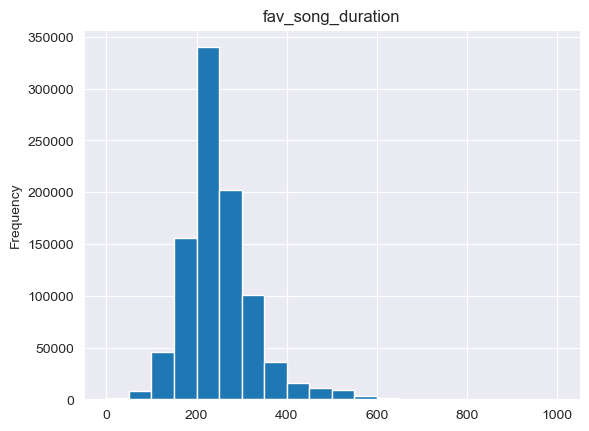

In [10]:
hist_var = 'fav_song_duration'  #"unqiue_song_count"#'fav_song_duration'
users_df[hist_var].plot(
    kind='hist',
    bins=20,
    title=hist_var,
    range=(0, 1000)  # min is 10
)

#### Filter Data

In [11]:
#playlists are generated for users who listen to more than 10 different songs (i.e the size of our playlist)
# we can just recommend generic songs to users that don't or are new
filtered_users_df = users_df[users_df['unqiue_song_count'] > 10]
#we only sonsider user that like listening to tracks/songs that are more than 30 seconds and less than 10 minutes
filtered_users_df = filtered_users_df[filtered_users_df['fav_song_duration'] > 30]
filtered_users_df = filtered_users_df[filtered_users_df['fav_song_duration'] < 600]
filtered_users_df = filtered_users_df[filtered_users_df['total_play_time'] < 70000]
filtered_users_df = filtered_users_df[filtered_users_df['total_play_count'] < 5000]
filtered_users_df = filtered_users_df[filtered_users_df['total_play_count'] > 10]

len(filtered_users_df)

574660

In [12]:
users_df = filtered_users_df

In [13]:
users_df = users_df[users_df['total_play_count'] < 200]
users_df = users_df[users_df['total_play_count'] > 24]
users_df = users_df[users_df['unqiue_song_count'] > 15]
users_df = users_df[users_df['fav_year'] > 2000]
users_df = users_df[users_df['total_play_time'] < 70000]

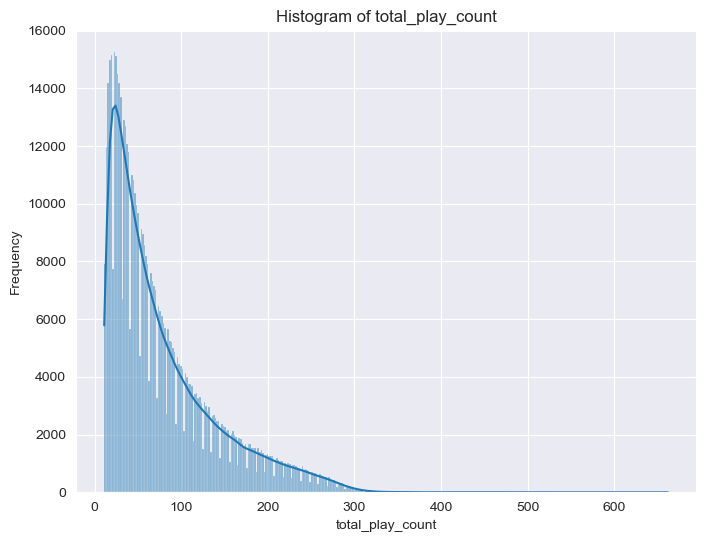

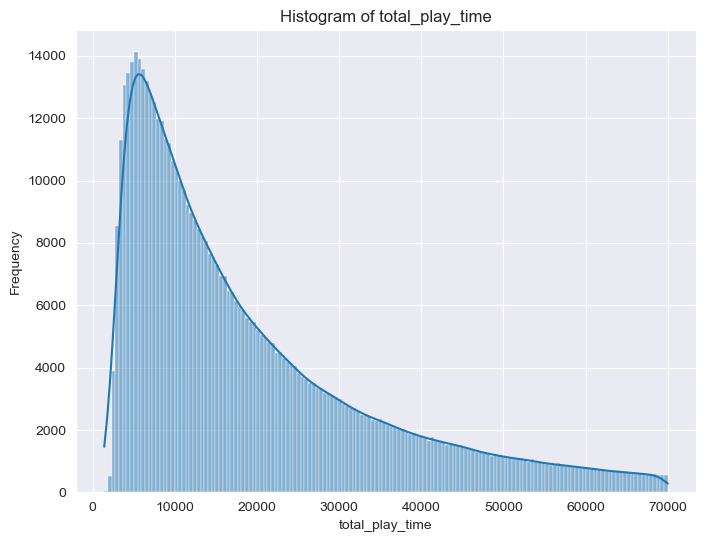

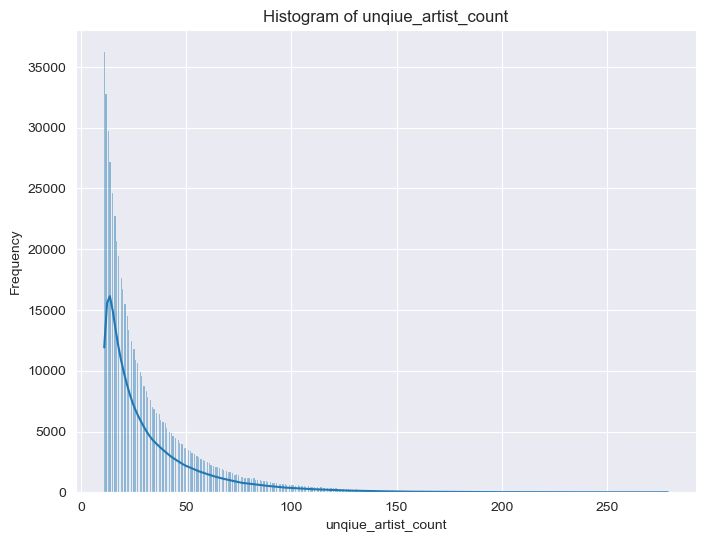

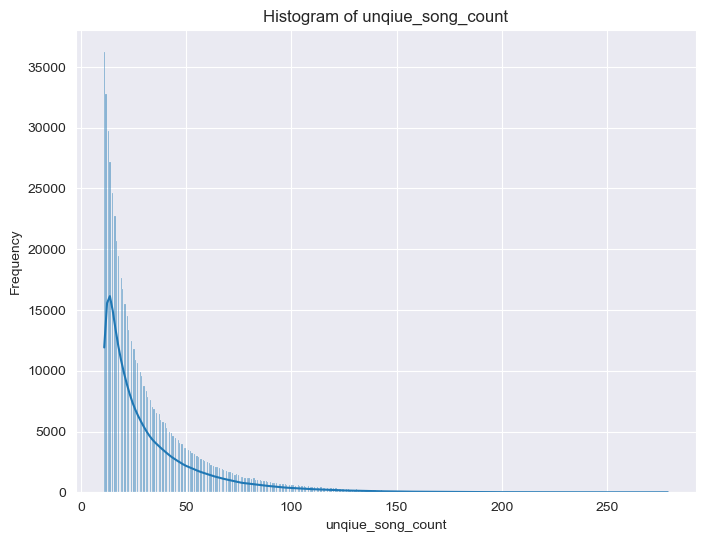

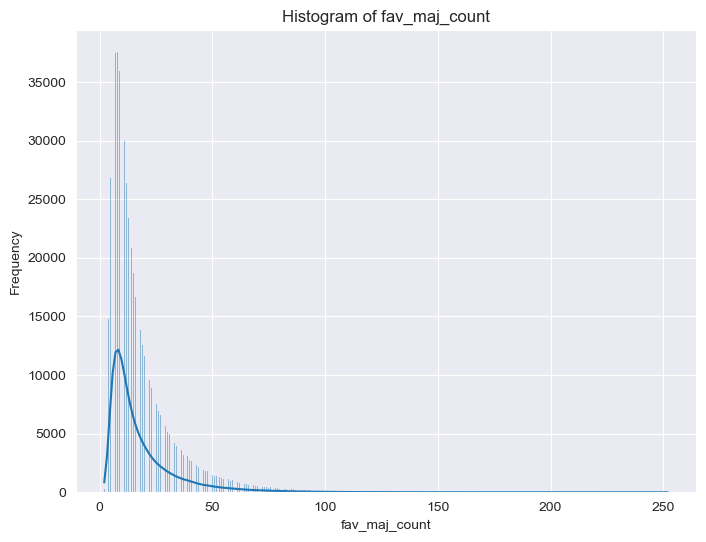

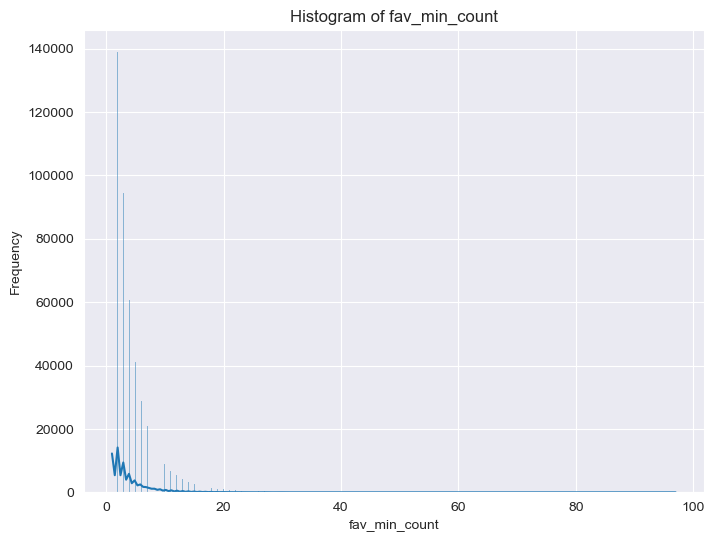

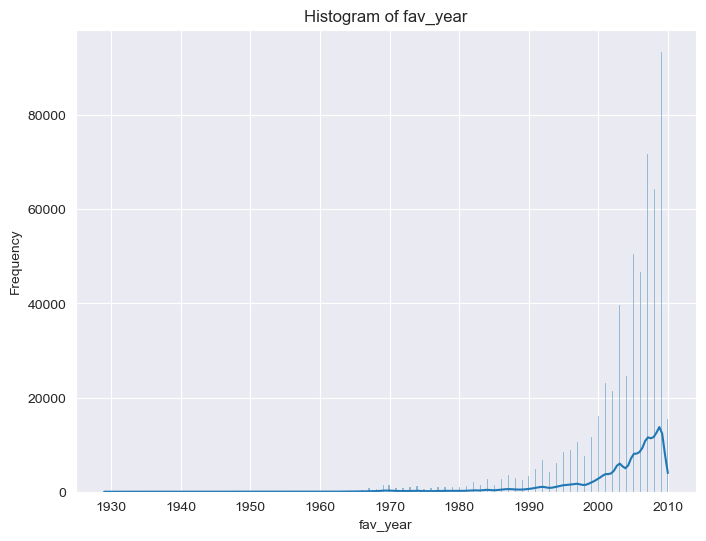

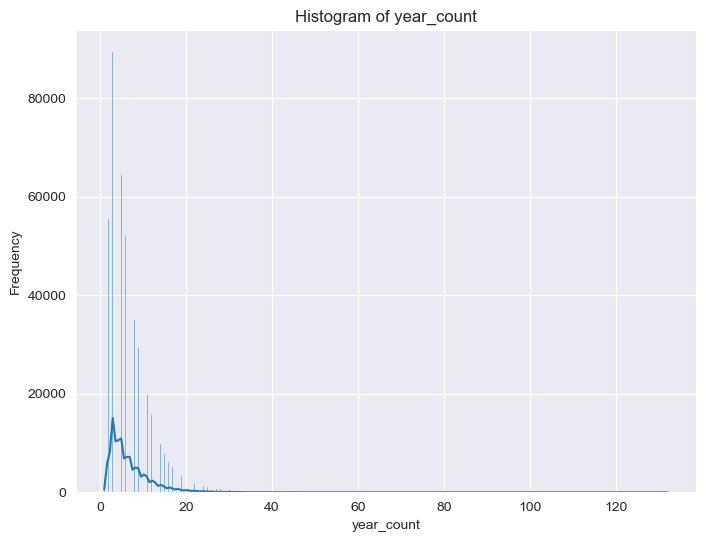

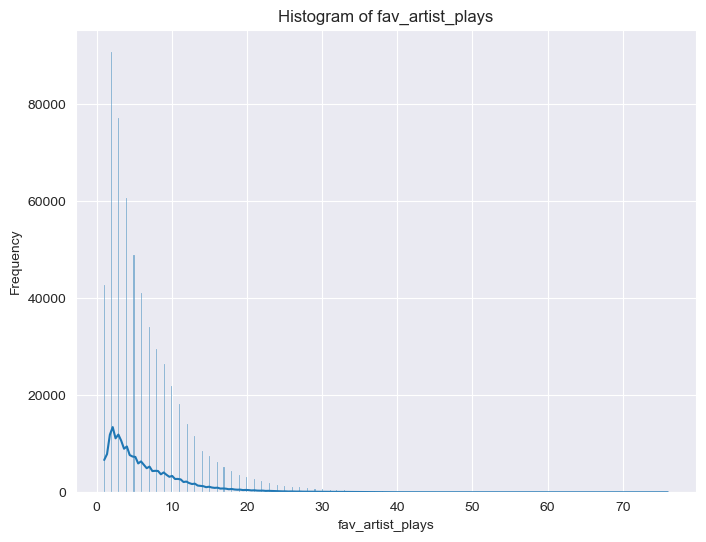

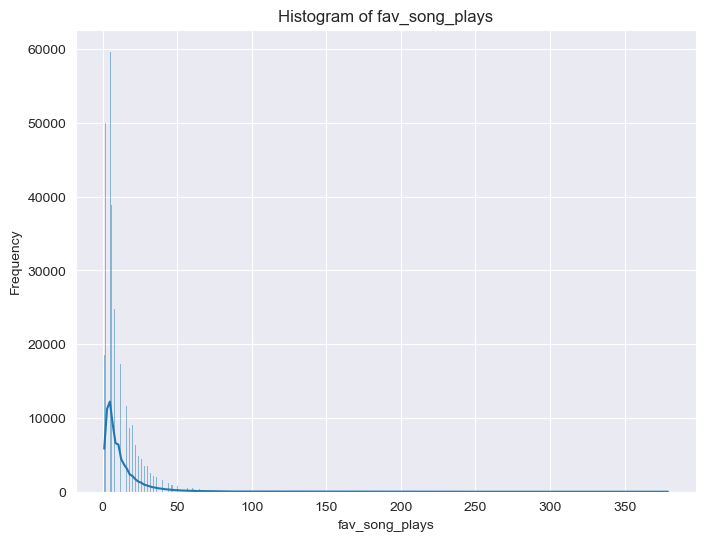

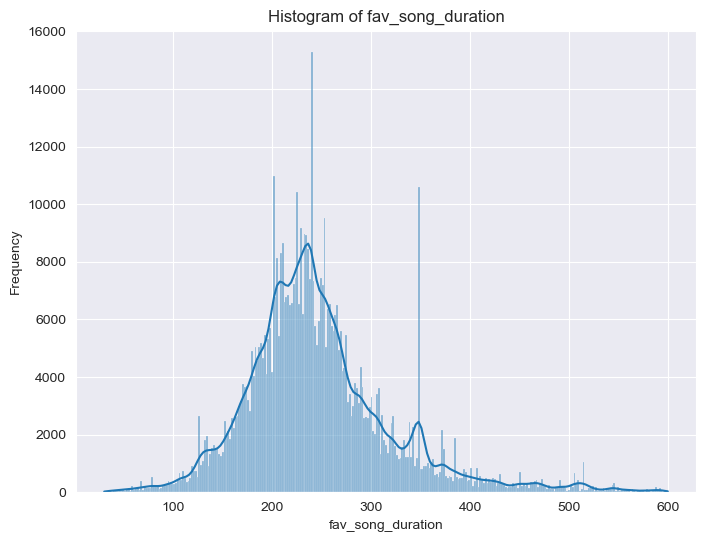

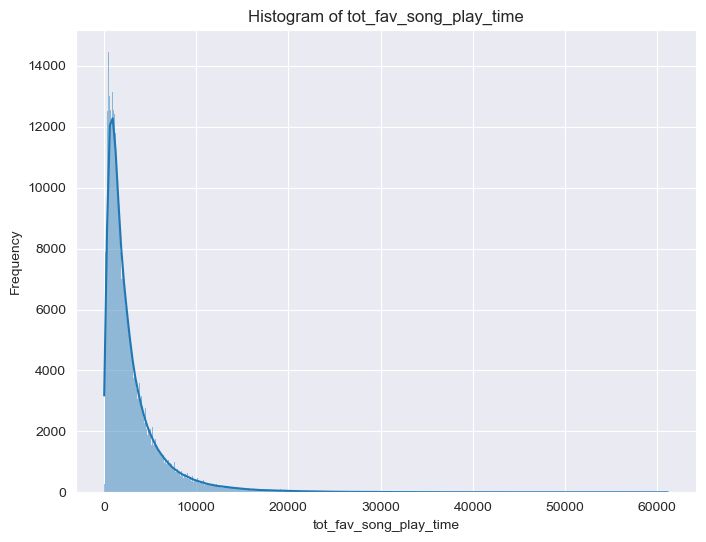

In [14]:
numerical_cols = filtered_users_df.select_dtypes(include=np.number).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(filtered_users_df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#### Scaling Numerical Features

After deciding not to drop users based on play count, we focused on scaling numerical features. We found `MinMaxScaler` was heavily influenced by outliers, compressing most data into a small range with a low mean. Based on scikit-learn documentation, we selected `RobustScaler` as it uses robust statistics (median and interquartile range) and is less sensitive to outliers, making it more suitable for our dataset.

In [15]:
# Select numerical columns to normalize and standardize
numerical_cols = users_df.select_dtypes(include=['number']).columns

# Initialize scalers
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()

# Apply minmax scaling
users_df_normalized = users_df.copy()
users_df_normalized[numerical_cols] = scaler_minmax.fit_transform(users_df_normalized[numerical_cols])

# Apply robust scaling
users_df_robustscaled = users_df.copy()
users_df_robustscaled[numerical_cols] = scaler_robust.fit_transform(users_df_robustscaled[numerical_cols])

print("Original Data:")
display(users_df[numerical_cols].describe())

print("MinMax Data:")
display(users_df_normalized[numerical_cols].describe())

print("Robust Scaled Data:")
display(users_df_robustscaled[numerical_cols].describe())

Original Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,292126.0,292126.0,292126.0,292126.0,292126.0,292126.0,292126.0,292126.0,292126.0,292126.0,292126.0,292126.0
mean,84.928699,20980.251347,38.371193,38.371193,21.480563,4.647645,2006.323162,8.358787,7.553583,12.211717,247.582665,3034.26978
std,45.602087,11549.250158,22.378637,22.378637,14.653762,4.068104,2.452268,4.710936,5.787211,11.420176,75.441173,3120.642935
min,25.0,3591.19802,16.0,16.0,3.0,1.0,2001.0,2.0,1.0,1.0,30.35383,39.49669
25%,47.0,11474.505135,22.0,22.0,12.0,2.0,2005.0,5.0,3.0,5.0,201.87383,1161.01
50%,74.0,18228.48788,31.0,31.0,17.0,3.0,2007.0,7.0,6.0,9.0,236.66893,2071.47996
75%,116.0,28478.171412,47.0,47.0,27.0,6.0,2008.0,11.0,10.0,15.0,277.83791,3750.73091
max,199.0,69867.22645,187.0,187.0,172.0,86.0,2010.0,101.0,72.0,172.0,599.69261,57009.5744


MinMax Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000
mean,0.344418,0.262373,0.130826,0.130826,0.109352,0.042913,0.591462,0.064230,0.092304,0.065566,0.381546,0.052567
std,0.262081,0.174260,0.130869,0.130869,0.086709,0.047860,0.272474,0.047585,0.081510,0.066785,0.132507,0.054777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.126437,0.118947,0.035088,0.035088,0.053254,0.011765,0.444444,0.030303,0.028169,0.023392,0.301262,0.019686
50%,0.281609,0.220853,0.087719,0.087719,0.082840,0.023529,0.666667,0.050505,0.070423,0.046784,0.362377,0.035668
75%,0.522989,0.375505,0.181287,0.181287,0.142012,0.058824,0.777778,0.090909,0.126761,0.081871,0.434687,0.065144
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Robust Scaled Data:


,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,fav_song_plays,fav_song_duration,tot_fav_song_play_time
count,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000,292126.000000
mean,0.158387,0.161834,0.294848,0.294848,0.298704,0.411911,-0.225613,0.226464,0.221940,0.321172,0.143670,0.371774
std,0.660900,0.679221,0.895145,0.895145,0.976917,1.017026,0.817423,0.785156,0.826744,1.142018,0.993116,1.205011
min,-0.710145,-0.860831,-0.600000,-0.600000,-0.933333,-0.500000,-2.000000,-0.833333,-0.714286,-0.800000,-2.715956,-0.784634
25%,-0.391304,-0.397207,-0.360000,-0.360000,-0.333333,-0.250000,-0.666667,-0.333333,-0.428571,-0.400000,-0.458047,-0.351571
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.608696,0.602793,0.640000,0.640000,0.666667,0.750000,0.333333,0.666667,0.571429,0.600000,0.541953,0.648429
max,1.811594,3.036918,6.240000,6.240000,10.333333,20.750000,1.000000,15.666667,9.428571,16.300000,4.778886,21.213905


One hot encode categorical data

The number of unique favorite arists: 14,975. This is manageable.

The number of unique favorite songs is 119,417. This takes too much RAM.

In [16]:
# Count unique categorical values
num_unique_artists = users_df['fav_artist'].nunique()
num_unique_songs = users_df['fav_song'].nunique()  # too many
num_unique_maj_genres = users_df['fav_maj_genre'].nunique()
num_unique_min_genres = users_df['fav_min_genre'].nunique()

print(f"Number of unique favorite artists: {num_unique_artists}")
print(f"Number of unique favorite songs: {num_unique_songs}")
print(f"Number of unique favorite major genres: {num_unique_maj_genres}")
print(f"Number of unique favorite minority genres: {num_unique_min_genres}")

Number of unique favorite artists: 6386
Number of unique favorite songs: 44951
Number of unique favorite major genres: 15
Number of unique favorite minority genres: 15


In [17]:
# Select categorical columns for one-hot encoding
# ['fav_song'] a ton of these guys = run out of ram if try to use so omit
users_df_robustscaled = users_df_robustscaled.drop(columns=["fav_song"])
# Features to do one-hot encoding on
categorical_cols = ['fav_maj_genre', 'fav_min_genre', 'fav_artist']
users_df_encoded = pd.get_dummies(users_df_robustscaled, columns=categorical_cols, dummy_na=False)

print("Original DataFrame shape:", users_df_robustscaled.shape)
print("DataFrame shape after one-hot encoding:", users_df_encoded.shape)
display(users_df_encoded.head())

Original DataFrame shape: (292126, 16)
DataFrame shape after one-hot encoding: (292126, 6429)


,user_id,total_play_count,total_play_time,unqiue_artist_count,unqiue_song_count,fav_maj_count,fav_min_count,fav_year,year_count,fav_artist_plays,...,fav_artist_ARZXNFV1187B9BA2CD,fav_artist_ARZXTEY1187B9997A7,fav_artist_ARZXZ731187B9B8813,fav_artist_ARZYJO61187B98F4B9,fav_artist_ARZYPLF1187FB45B9B,fav_artist_ARZYSCW1187FB52DF7,fav_artist_ARZYT8C1187FB4D57F,fav_artist_ARZYZUU11F4C841DCC,fav_artist_ARZZLLI1187B99C8DD,fav_artist_ARZZMWO1187B9AFB36
6,00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e,-0.275362,-0.350801,0.12,0.12,1.066667,-0.50,0.333333,0.500000,2.428571,...,False,False,False,False,False,False,False,False,False,False
9,00007ed2509128dcdd74ea3aac2363e24e9dc06b,-0.521739,-0.496359,0.04,0.04,0.600000,0.25,-1.000000,0.166667,1.571429,...,False,False,False,False,False,False,False,False,False,False
15,0000d3c803e068cf1da17724f1674897b2dd7130,-0.144928,-0.269273,0.12,0.12,-0.200000,0.75,-1.000000,-0.333333,0.000000,...,False,False,False,False,False,False,False,False,False,False
22,0001c671d4962f5449e225cab018d6ca290c7ad2,-0.637681,-0.657776,-0.24,-0.24,-0.066667,2.00,0.333333,0.666667,0.857143,...,False,False,False,False,False,False,False,False,False,False
24,0001cbd80da8b7be9e6fe8ef2d3749e68b08ecd2,0.101449,0.039291,0.52,0.52,-0.400000,1.50,-0.666667,1.666667,0.857143,...,False,False,False,False,False,False,False,False,False,False


### Save processed dataframe

In [18]:
# if local
users_cleaned_and_encoded_path = "data/users_cleaned_encoded_df.parquet"

In [19]:
# # if collab
# users_cleaned_and_encoded_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df_encoded.parquet"

In [20]:
# Save the processed dataframe to Parquet
users_df_encoded.to_parquet(users_cleaned_and_encoded_path, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {users_cleaned_and_encoded_path}")

Processed DataFrame saved to: data/users_cleaned_encoded_df.parquet
